In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr, ttest_ind
from tools import min_max_normalization, case_selection

from datetime import datetime

DATE = datetime.today().strftime("%Y-%m-%d")

In [2]:
NEGATIVES = ("SH.DYN.MORT", "SH.TBS.INCD")
PROXIES_WEIGHT = {
    'MS.MIL.TOTL.TF.ZS': 2, # Armed forces personnel (% of total labor force)
    'MS.MIL.XPND.GD.ZS': 1, # Military expenditure (% of GDP)
    
    'EG.ELC.ACCS.RU.ZS': 1, # Access to electricity, rural (% of rural population)
    'EG.USE.ELEC.KH.PC': 1.5, # Electric power consumption (kWh per capita)
    'SH.DYN.MORT': 2, # Mortality rate, under-5 (per 1,000 live births)
    'SH.MED.BEDS.ZS': 1.5, # Hospital beds (per 1,000 people)
    'SH.TBS.INCD': 2, # Incidence of tuberculosis (per 100,000 people)
    'IS.RRS.PASG.KM': 1, # Railways, passengers carried (million passenger-km)
    'SH.H2O.BASW.ZS': 1, # People using at least basic drinking water services (% of population)
    'SH.H2O.SMDW.ZS': 1, # People using safely managed drinking water services (% of population)
    #'GC.TAX.TOTL.GD.ZS': 1, # Tax revenue (% of GDP)
    #'IQ.CPA.FISP.XQ': 1 # CPIA fiscal policy rating (1=low to 6=high)
}

YEARS = (2000, 2003, 2004, 2005, 2009, 2010, 2014)
SUCCESSFUL_TRANSITION = ("SRB", "UKR", "GEO")

In [3]:
def stateness_calculation(df, selected_cases=True):
    
    dataset = df.copy()
    dataset["proxy_weight"] = dataset["id"].map(PROXIES_WEIGHT)
    
    positives = dataset.loc[~dataset["id"].isin(NEGATIVES)].copy()
    negatives = dataset.loc[dataset["id"].isin(NEGATIVES)].copy()
    
    positives["norm"] = positives.groupby(["year", "id"])["value"].transform(min_max_normalization)
    negatives["norm"] = negatives.groupby(["year", "id"])["value"].transform(min_max_normalization, reverse=True)
    stateness = pd.concat([positives, negatives], ignore_index=False).sort_values(["year", "id"])
    
    stateness["proxy_score"] = stateness["norm"] * stateness["proxy_weight"] 
    g = stateness.groupby(["year", "iso3"], as_index=False)["proxy_score"].sum()
    g["stateness"] = g["proxy_score"] / sum(PROXIES_WEIGHT.values()) * 100
    g["successful_transition"] = g["iso3"].isin(SUCCESSFUL_TRANSITION).astype(int)
    g["approach"] = "max definition"
    
    return case_selection(g) if selected_cases else g

In [4]:
data = pd.read_excel("./../data/interim/world-bank-data_2020-05-27 22_30.xlsx")
df = data.loc[data["year"].isin(YEARS) & data["id"].isin(PROXIES_WEIGHT.keys())].copy()

In [5]:
# show results for all countries
stateness_calculation(df, selected_cases=False)

,year,iso3,proxy_score,stateness,successful_transition,approach
0,2000,ARM,7.263387,51.881337,0,max definition
1,2000,AZE,5.283407,37.738620,0,max definition
2,2000,BLR,9.680646,69.147470,0,max definition
3,2000,EST,9.119360,65.138283,0,max definition
4,2000,GEO,3.651742,26.083874,1,max definition
...,...,...,...,...,...,...
107,2014,SRB,7.338370,52.416928,1,max definition
108,2014,TJK,1.567041,11.193151,0,max definition
109,2014,TKM,5.092444,36.374599,0,max definition
110,2014,UKR,6.690406,47.788615,1,max definition


In [6]:
# show results for selected countries
stateness_calculation(df, selected_cases=True)

,year,iso3,proxy_score,stateness,successful_transition,approach
11,2000,SRB,7.661516,54.725112,1,max definition
20,2003,GEO,4.101782,29.298443,1,max definition
46,2004,UKR,7.414594,52.961388,1,max definition
54,2005,KGZ,3.886213,27.758666,0,max definition
73,2009,MDA,4.829587,34.497050,0,max definition
86,2010,KGZ,3.336018,23.828700,0,max definition
110,2014,UKR,6.690406,47.788615,1,max definition


In [7]:
max_definition = stateness_calculation(df, selected_cases=True)
max_definition.to_excel(f"./../data/interim/max-definition_{DATE}.xlsx", index=False)

---

In [8]:
rcParams["font.size"] = 10
rcParams["figure.figsize"] = 16, 10

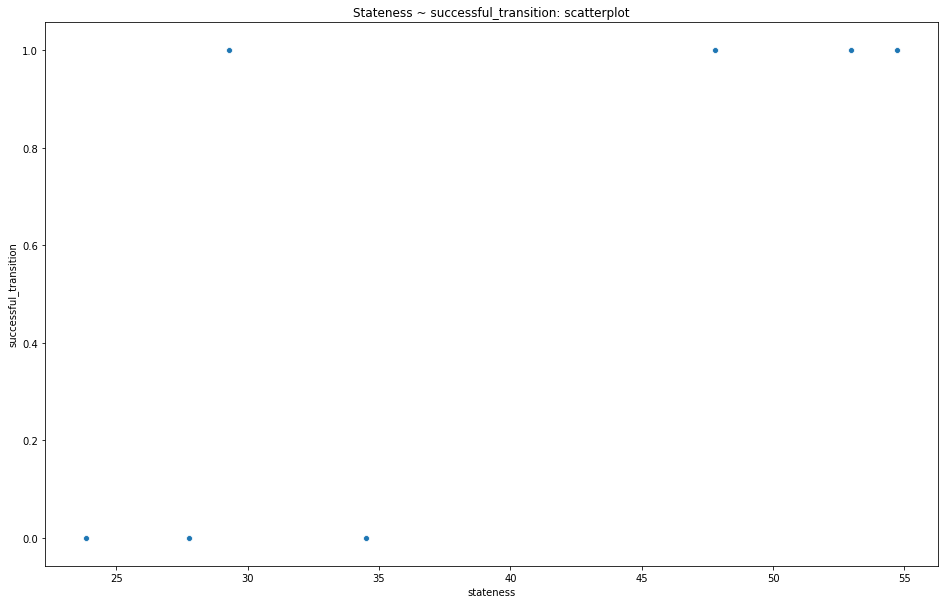

In [9]:
fig = sns.scatterplot(x="stateness", y="successful_transition", data=max_definition)
fig.set_title("Stateness ~ successful_transition: scatterplot")
plt.show()

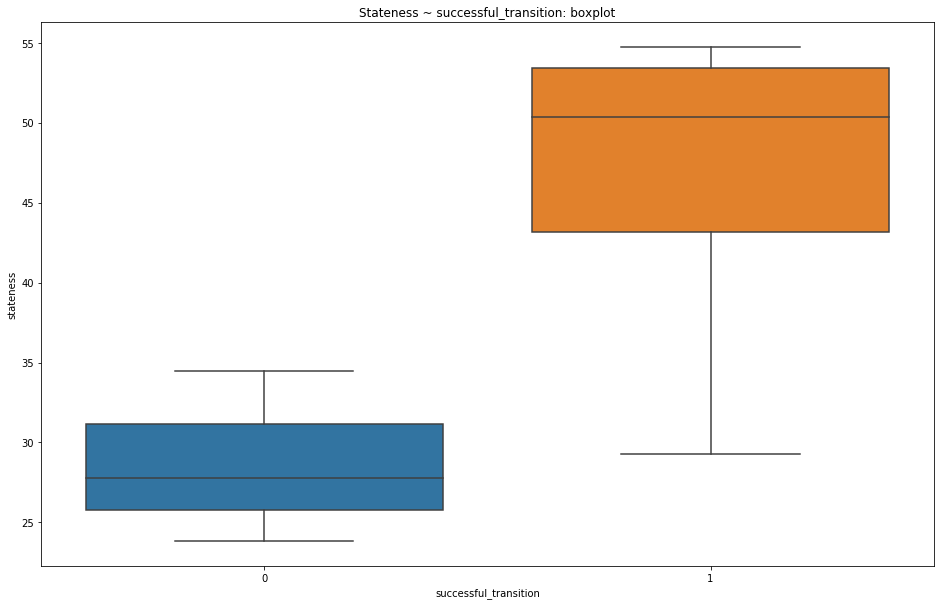

In [10]:
fig = sns.boxplot(x="successful_transition", y="stateness", data=max_definition)
fig.set_title("Stateness ~ successful_transition: boxplot")
plt.show()

In [11]:
statistic, pvalue = ttest_ind(max_definition["stateness"], max_definition["successful_transition"])

In [12]:
statistic

7.846493032184952

In [13]:
pvalue

4.58222462829539e-06

In [14]:
pvalue < 0.01

True